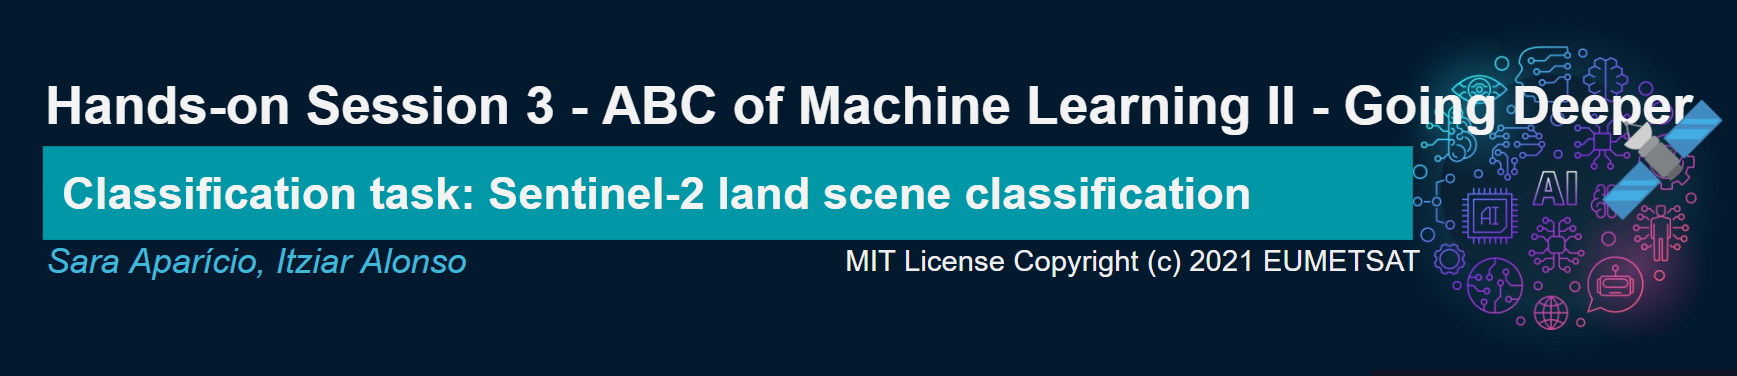

LECTURER'S VERSION - DO NOT EDIT

### Goal:
Classifiy Sentinel-2 tiles in 10 different categories of landcover, using a multilayer perceptron (MLP) neural network.

### Deep learning (image classification) workflow:
- **Step 0:** Import all libraries (overview of libraries in this notebook)
- **Step 1:**  Load the data
    - Step 1.1: Inspect the data
    - Step 1.2: Normalize the data
    - Step 1.3: One-hot encode the values 
- **Step 2:** Create the model
- **Step 3:** Compile the model
- **Step 4:** Train the model
- **Step 5:** Evaluate model
- **Step 6:** Use the model to make predictions

_________________________
### Step 0: Import all libraries
Need the following packages:

- **TensorFlow** is an open source library created for Python by the Google Brain team. TensorFlow compiles many different algorithms and models together, enabling the user to implement deep neural networks for use in tasks like image recognition/classification and natural language processing. TensorFlow is a powerful framework that functions by implementing a series of processing nodes, each node representing a mathematical operation, with the entire series of nodes being called a "graph".

- **Keras** is a high-level Deep Learning API that allow to easily build, train, evaluate and execute all sorts of neural netowrks. It uses TensorFlow's functions underneath and was designed with user-friendliness and modularity as its guiding principles. In practical terms, Keras makes implementing the many powerful but often complex functions of TensorFlow as simple as possible, and it's configured to work with Python without any major modifications or configuration.

In [17]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils\

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
#Set random seed for purposes of reproducibility
#seed = 21

### Step 1: Load the data
When loading data using Keras rather than Scikit-Learn, one important difference is that every image is presented as a ## x ## array rather than a 1D array of size ###. Moreover, the pixel intensities are represented as integer (from 0 to 255) rather than floats (from 0.0 to 255.0).

The training data used for this exercice belongs to the EuroSat dataset and can be accessible at https://www.kaggle.com/apollo2506/eurosat-dataset. 

Kaggle is the world's largest data science community with powerful tools and resources. You can find repositories of training datasets. 

Each image is **64 x 64 pixels**, and where collected from Sentinel-2 satellite. 
- EuroSAT contains RGB images (i.e. 3 bands) in JPG format.
- EuroSATallBands has the bands of the spectrum in .tiff format.

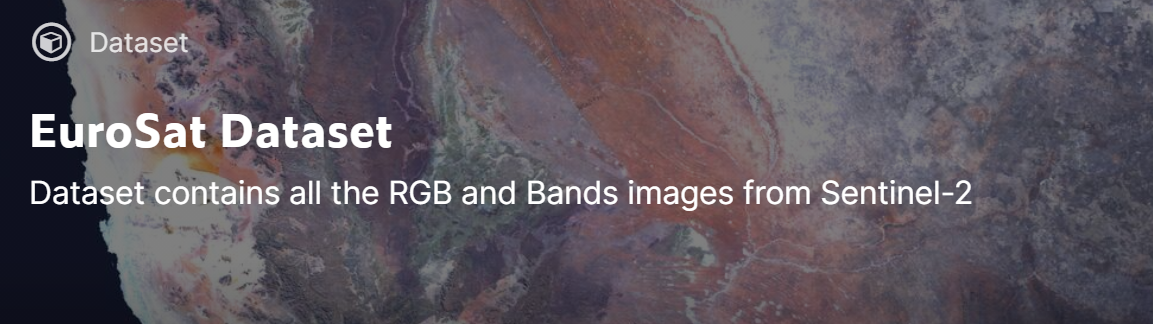




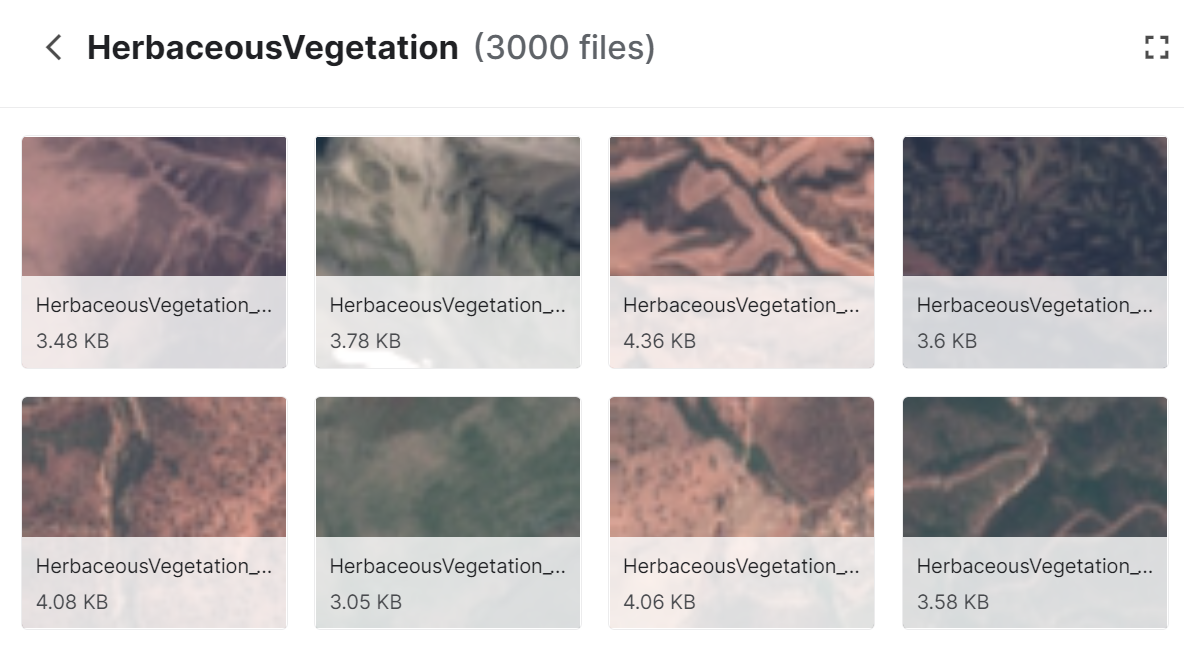

#### Step 1.1. Inspect the data
A first step is to **explore** your training data: have a look at it, and understanding its shape and data type. 

In [19]:
#create a path to where EuroSAT data is stored
path = '/home/jupyter-mleo/ml-for-eo/session-3-handson-image-classification/data/EuroSAT/'

dataset = image_dataset_from_directory(path,labels = "inferred", label_mode = 'categorical', image_size = (64, 64))
class_names = ['AnnualCrop','Forest', 'HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']
               

Found 27000 files belonging to 10 classes.


In [20]:
#this code block aims at creating dataframes with 
# the X and y variables
sample1df = pd.read_csv(path + 'train.csv')
sample2df = pd.read_csv(path + 'validation.csv')
sample3df = pd.read_csv(path + 'test.csv')

#creates a dataframe with all the files names
s1fname = sample1df.Filename
s2fname = sample2df.Filename
s3fname = sample3df.Filename

#creates a datagrame withh all the labels
s1label = sample1df.Label
s2label = sample2df.Label
s3label = sample3df.Label

#exmaple:
print('Example file name:' ,s1fname[380])
print('Example file label:', s1label[380])
sample1df = sample1df.drop('Unnamed: 0', 1)
sample1df.head(3)

Example file name: AnnualCrop/AnnualCrop_1836.jpg
Example file label: 0


,Filename,Label,ClassName
0,AnnualCrop/AnnualCrop_142.jpg,0,AnnualCrop
1,HerbaceousVegetation/HerbaceousVegetation_2835...,2,HerbaceousVegetation
2,PermanentCrop/PermanentCrop_1073.jpg,6,PermanentCrop


In [21]:
#checking how many instances are inside each label/category
_, train_labels_count = np.unique(sample1df['Label'],return_counts=True)

train_count_df = pd.DataFrame(data = train_labels_count)
train_count_df['ClassName'] = class_names
train_count_df.columns = ['Count','ClassName']
train_count_df.set_index('ClassName',inplace=True)

train_count_df.head(9)

,Count
ClassName,
AnnualCrop,2100
Forest,2100
HerbaceousVegetation,2100
Highway,1750
Industrial,1750
Pasture,1400
PermanentCrop,1750
Residential,2100
River,1750


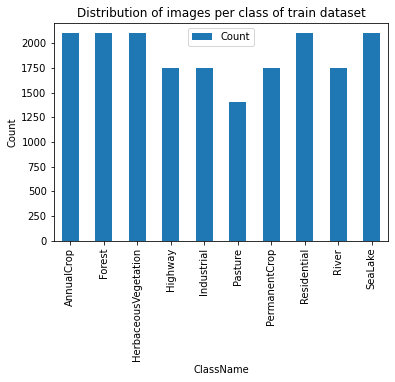

In [22]:
train_count_df.plot.bar()
plt.title("Distribution of images per class of train dataset")
plt.ylabel("Count");

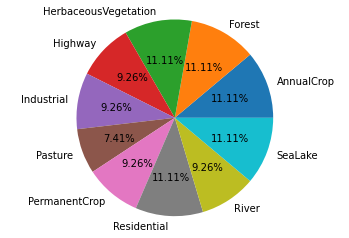

In [23]:
plt.pie(train_count_df.Count,
       explode = (0,0,0,0,0,0,0,0,0,0),
       labels = class_names,
       autopct="%1.2f%%")
plt.axis('equal');

In [24]:
#goes through the list of filenames, opens each file, converts to array
image1 = []
for fname in s1fname:
    Image = image.load_img(path + fname)  
    image_arr = image.img_to_array(Image)
    image1.append(image_arr)
    
image2 = []
for fname in s2fname:
    Image = image.load_img(path + fname)  
    image_arr = image.img_to_array(Image)
    image2.append(image_arr)

image3 = []
for fname in s3fname:
    Image = image.load_img(path + fname)  
    image_arr = image.img_to_array(Image)
    image3.append(image_arr)

In [25]:
##load here the data into X_train and y_train and y_train and y_test
X_train = image1 + image2
y_train = np.array(list(s1label) + list(s2label))
X_test = image3
y_test = np.array(s3label)

In [26]:
import rasterio
i = 30   # change i to see different classes
imagePath = path + s1fname[i]
image = rasterio.open(path + s1fname[i])

#show(image, title= class_names[s1label[i]])


/opt/tljh/user/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


#### Step 1.2. Normalize the data
Since we are going to train the neural network using **Gradient descent** we must **scale** the input features. 

For simplicity pixel intesities can be scaled down to the 0-1 range, by divinding them by 255.0 (this also converts them to floats since they are integers). 

In [27]:
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255

print('X train shape is',X_train.shape)
print('X train type is',X_train.dtype)
print('y train shape is',y_train.shape)
print('y train type is',y_train.dtype)

X train shape is (24300, 64, 64, 3)
X train type is float32
y train shape is (24300,)
y train type is int64


In [28]:
#reserve 10k samples for validation
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

#### Step 1.3 One-hot encode the values 
Images cannot be used by the network as they are, they need to be encoded first and one-hot enconding is best used when doing binary classification. Converts a class vector (integers) to binary class matrix.

For **categorical variables** where no ordinal relanship exists, integer encoding would not work. One-hot encoding is applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value. Since we have here *ten categories*, therefore 10 binary variables are needed. A **"1"** value is placed in the binary variable of a certain variable, and **"0"** is assigned to the others.

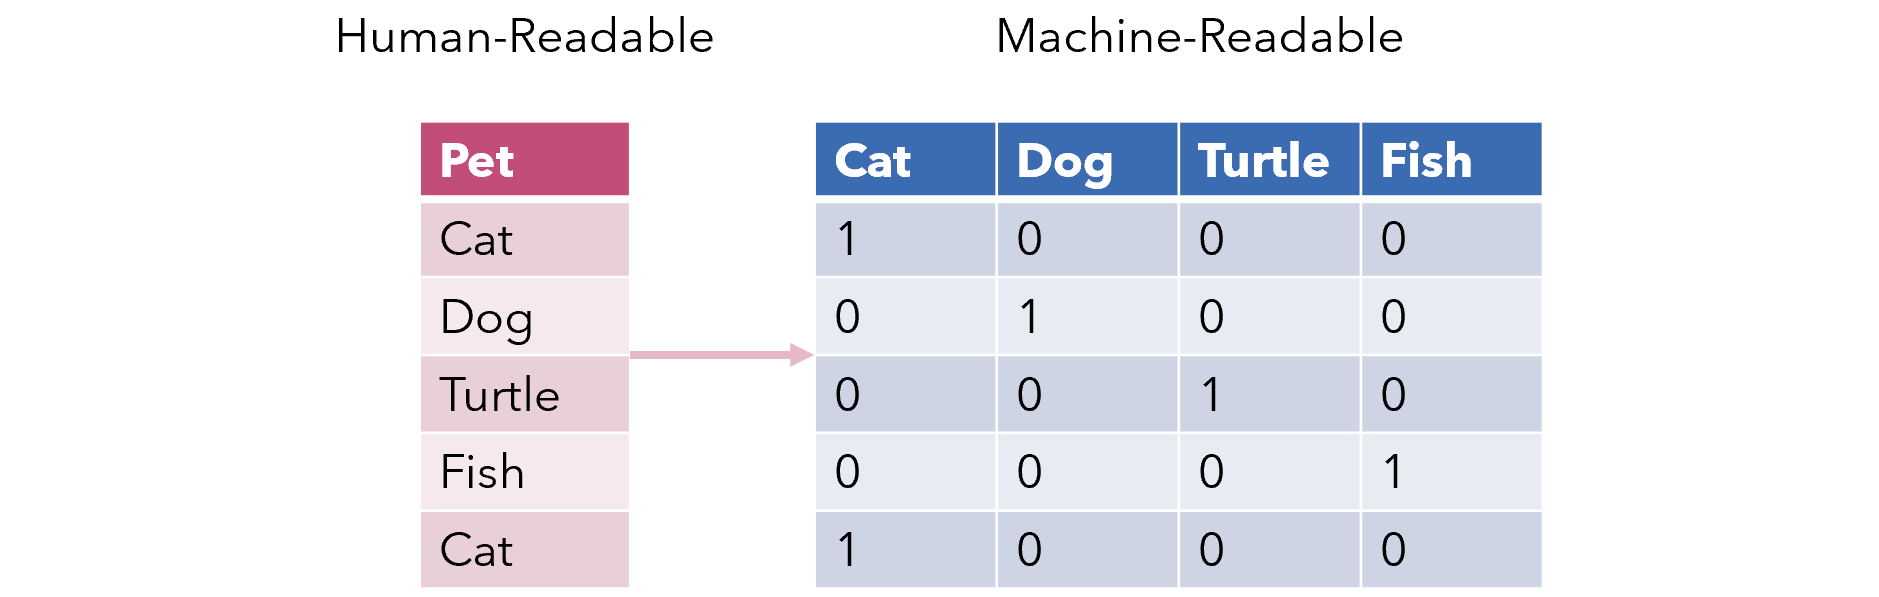

Summary:

- Categorical data is defined as variables with a finite set of label values.
- Most machine learning algorithms require numerical input and output variables.
- One hot encoding is used to convert categorical data to integer data.

In [29]:
#one-hot encoding 
y_train = to_categorical(y_train, 10)
y_test= to_categorical(y_test, 10)
class_num = y_test.shape[1]

print(y_train)
#print(class_num)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Step 2: Creating a MLP model with two hidden layers

A multilayer perceptron (MLP) is a cascade of single-layer perceptrons. We can summarize the types of layers in an MLP as follows:
- **Input Layer:** Input variables, sometimes called the visible layer.
- **Hidden Layers(s):** Layers of nodes between the input and output layers. There may be one or more of these layers.
- **Output Layer:** A layer of nodes that produce the output variables.
A classification MLP with two hidden layers:
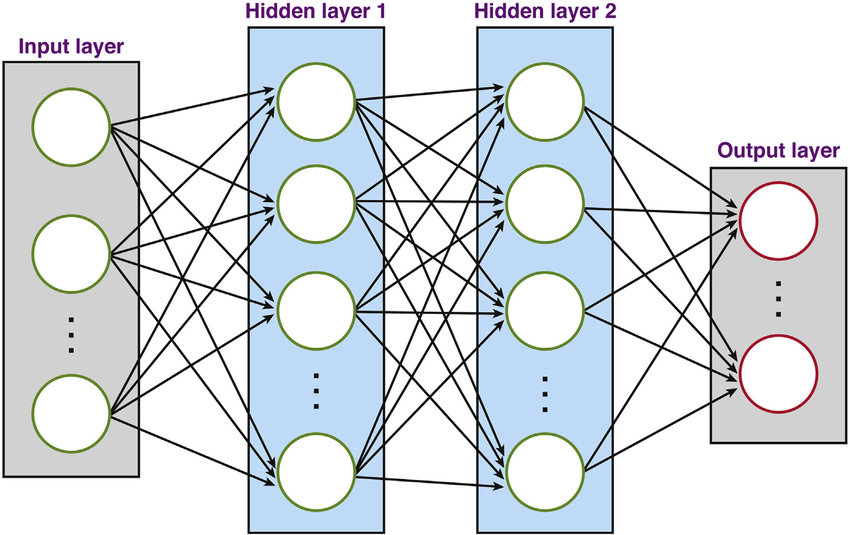

**The Sequential model API** is a way of creating deep learning models where an instance of the Sequential class is created and model layers are created and added to it. The Sequential model API is great for developing deep learning models in most situations, but it also has some limitations.


There are no universal rules for choosing an activation fucntion for hidden layers - however the activation function for the output layer will grately depend on the type of prediction required. Below there are some of the most widely used activations functions for hidden layers (according to the type of NN) and acitvation functions for output layers (according to the ML task).
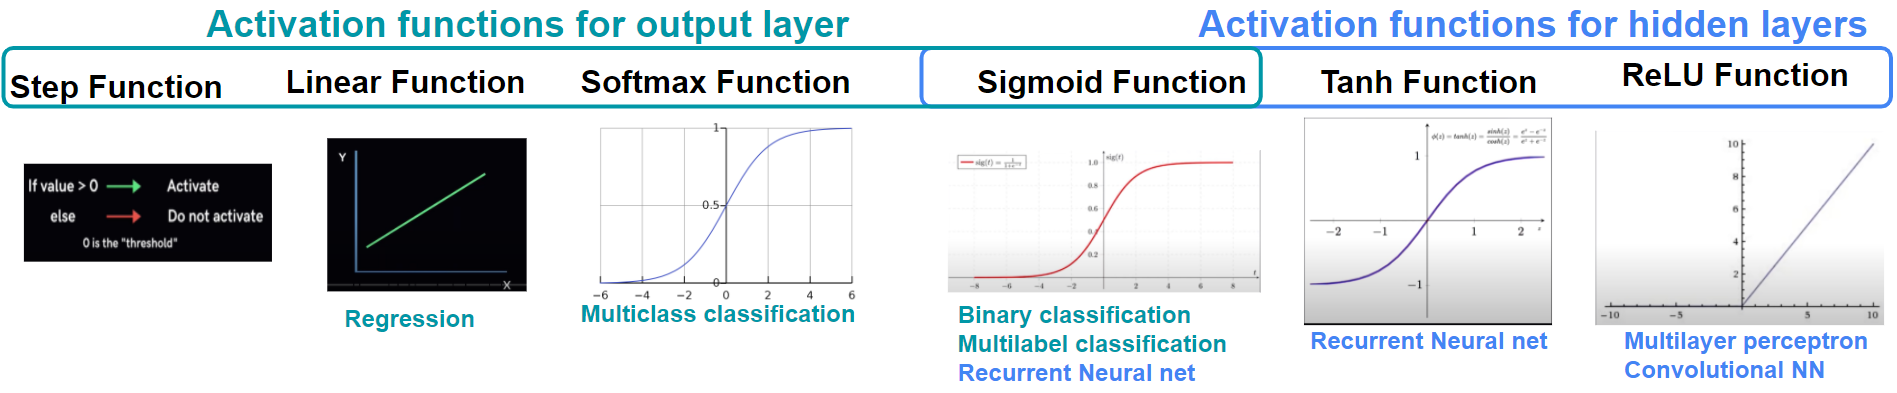


#### Step 2.1: Build the model

In [30]:
#Create a sequential model: this is the simplest kind of Keras model for NN 
#that are just compsed of a single stack of layers connected sequentially

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(64, 64, 3)),    # creates a layer converts each image into 1D array
                                                      # only contains number of pixels and bands X x X (no batch size)
   
    keras.layers.Dense(300, activation='relu'),       #adding dense hidden layer with 300 neurons with activation ReLu.
                                                      #each dense layer manages its own weight matrix + vector of bias
   
    keras.layers.Dense(100, activation='relu'),       #adding dense hidden layer with 100 neurons with activation ReLu
  
    keras.layers.Dense(10, activation='softmax')      #should be 10 neurons - one per class. Softmax activation because classes are exclusive!
])

In [31]:
#Another way of building the model: adding stak of layers

model = keras.Sequential()

model.add(keras.layers.Flatten(input_shape=(64,64,3)))
model.add(keras.layers.Dense(300,activation='relu'))
model.add(keras.layers.Dense(200,activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))


#### 2.2 Model's summary
The model's **sumary()** method displays all the model's layers, including their name (which is automatic unless it is specified), its output shape (**None** means the batch size can be anythin), and its numbers of parameters.

Note that the first hidden layer has 12288 x 400 connection weights, plus 400 bias terms - wich adds up to 4915600 parameters. This gives the model a lot of flexibility to fit the training data, but also it also means that the model runs the risk of **overfitting**. 

In [32]:
#visualize de model, displaying all the models' layers
#Includes layers names and its number of parameters
#print(model.summary())
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               3686700   
_________________________________________________________________
dense_4 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2010      
Total params: 3,748,910
Trainable params: 3,748,910
Non-trainable params: 0
_________________________________________________________________


### Step 3: Compiling the model
After the model is created, compiling the model specifies the **loss function** and **optmizer** to use. Optionally you can also specify a list of extra metrics to compute during training and evaluation.
The loss function, optmizers and metrics can be selected from:
- http://keras.io/losses
- http://keras.io/optimizers
- http://keras.io/metrics

In [33]:
model.compile(
             #we have one target probability per class for each instance, we used one-hot vector
            loss='categorical_crossentropy', 
            #stochastic gradient descent - keras will use the backpropagation algorith
            optimizer='sgd', 
            #it is a classifier, hence it's useful to measure the accuracy
             metrics=['accuracy'])

### Step 4: Training the model

Use X_train and y_train to fit the model. Selection of **epochs**.
An **epoch** is a term used in machine learning and indicates the number of passes of the entire training dataset the machine learning algorithm has completed. Datasets are usually grouped into batches (especially when the amount of data is very large). Some people use the term iteration loosely and refer to putting one batch through the model as an iteration.   

If the batch size is the whole training dataset then the number of epochs is the number of iterations. For practical reasons, this is usually not the case. Many models are created with more than one epoch. The general relation where dataset size is d, number of epochs is e, number of iterations is i, and batch size is b would be d*e = i*b. 

Determining how many epochs a model should run to train is based on many parameters related to both the data itself and the goal of the model, and while there have been efforts to turn this process into an algorithm, often a deep understanding of the data itself is indispensable.

In [46]:
print("Fit model on training data:")
history = model.fit(X_train,y_train, epochs=15)#,validation_data=(X_val,y_val)) 
 #validation is passed for monitoring loss and metrics at the end
                   #of each epoch 


Fit model on training data:
Epoch 1/15
447/447 [==============================] - 4s 9ms/step - loss: 0.9863 - accuracy: 0.6499
Epoch 2/15
447/447 [==============================] - 4s 9ms/step - loss: 0.9760 - accuracy: 0.6524
Epoch 3/15
447/447 [==============================] - 4s 9ms/step - loss: 0.9658 - accuracy: 0.6569
Epoch 4/15
447/447 [==============================] - 3s 8ms/step - loss: 0.9721 - accuracy: 0.6515
Epoch 5/15
447/447 [==============================] - 4s 9ms/step - loss: 0.9557 - accuracy: 0.6600
Epoch 6/15
447/447 [==============================] - 4s 9ms/step - loss: 0.9483 - accuracy: 0.6636
Epoch 7/15
447/447 [==============================] - 4s 8ms/step - loss: 0.9354 - accuracy: 0.6678
Epoch 8/15
447/447 [==============================] - 3s 8ms/step - loss: 0.9310 - accuracy: 0.6646
Epoch 9/15
447/447 [==============================] - 3s 8ms/step - loss: 0.9332 - accuracy: 0.6692
Epoch 10/15
447/447 [==============================] - 3s 8ms/step - los

### Step 5. Evaluate the model

<function matplotlib.pyplot.show(close=None, block=None)>

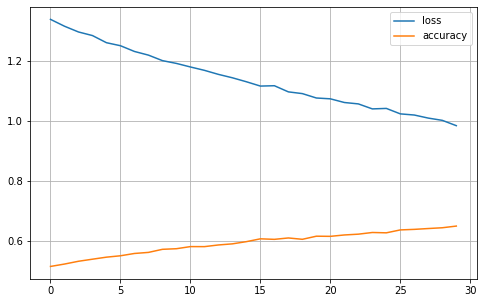

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca()#.set_ylim(0,1) #sets vertical range to [0-1]
plt.show

In [37]:
model.evaluate(X_test,y_test)
#print("Accuracy: %.2f%%" % (scores[1]*100))

85/85 [==============================] - 1s 2ms/step - loss: 1.2414 - accuracy: 0.5637


[1.241420865058899, 0.563703715801239]

### Step 6. Using the model to make predictions
We can use now predict to make predictions on new instances. We can use for example, the first three instances from the validation set:

Highway


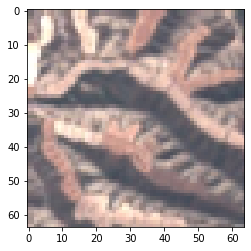

In [45]:
class_names = ['AnnualCrop','Forest', 'HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']
       
# change number of image_index (e.g. 60, 7, 88), to see different predictions
image_index = 500
plt.imshow(X_test[image_index])
pred = model.predict(X_test[image_index].reshape(1, 64, 64, 3))
predicted_class = pred.argmax()
class_nm = class_names[predicted_class]
print(class_nm)


['AnnualCrop']


/opt/tljh/user/lib/python3.7/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


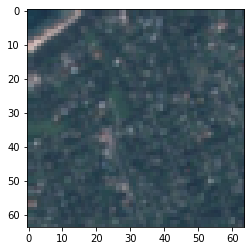

In [39]:
X_new = X_test[:1]
plt.imshow(X_test[1])
y_pred = model.predict_classes(X_new)
y_pred

a = np.array(class_names)[y_pred]


print(a)